In [32]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


In [33]:
# Some useful functions
def show_image(image,title="",c_stretch=True,cmap=None):
    if c_stretch:
        vmin = image.min()
        vmax = image.max()
    else:
        vmin = 0
        vmax = 255
    
    plt.imshow(image,vmin=vmin,vmax=vmax,cmap=cmap)
    plt.axis("off")
    plt.title(title)

 

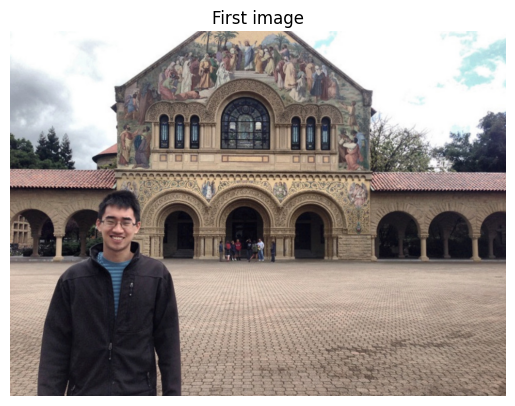

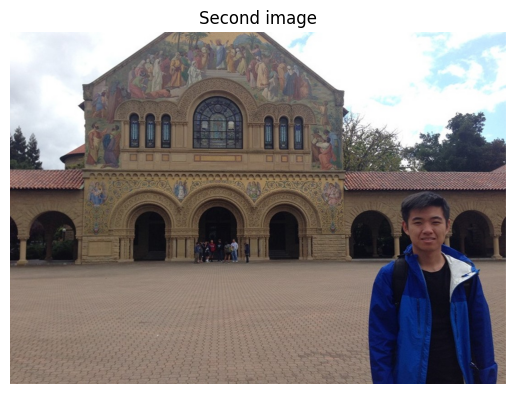

In [34]:
   
# Importing images

man = cv.imread("man.png")
man = cv.cvtColor(man,cv.COLOR_BGR2RGB)
man2 = cv.imread("man2.jpg")
man2 = cv.cvtColor(man2,cv.COLOR_BGR2RGB)

show_image(man,"First image")
plt.figure()
show_image(man2,"Second image")

In [35]:
def histMatching(in_img,ref_img):
    # getting histogram
    out = np.copy(in_img)
    count_out = np.zeros(256)
    for i in out.flatten():
        count_out[i] += 1
    count_ref = np.zeros(256)
    for i in ref_img.flatten():
        count_ref[i] += 1
    # cumsum
    for i in range(255):
        count_out[i + 1] += count_out[i]
    for i in range(255):
        count_ref[i + 1] += count_ref[i]
    # Normalization
    arr_out = (count_out - count_out.min()) * 255
    arr_ref = (count_ref - count_ref.min()) * 255
    scale_out = count_out.max() - count_out.min()
    scale_ref = count_ref.max() - count_ref.min()
    count_out = arr_out/scale_out
    count_ref = arr_ref/scale_ref
    count_out = count_out.astype('uint8')
    count_ref = count_ref.astype('uint8')
    # We map each pixel x to the pixel value y so that the pixel x value in the input picture histogram is closest to the pixel y value in the reference image histogram.
    mapping = np.array([ np.abs(count_ref - count_out[i]).argmin() for i in range(256) ])
    for x in range(out.shape[0]):
        for y in range(out.shape[1]):
            out[x][y] = mapping[out[x][y]]
    return out
    

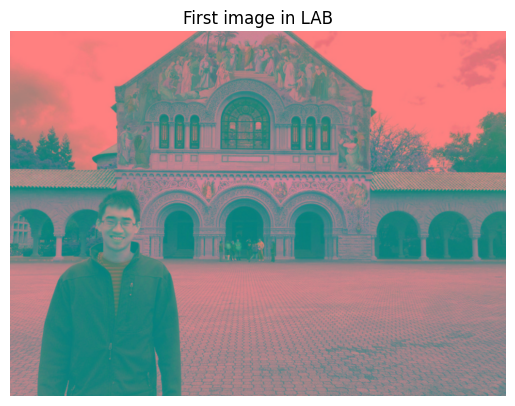

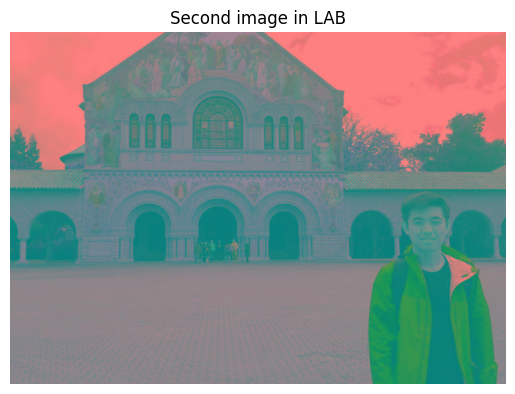

In [36]:
man_lab = cv.cvtColor(man,cv.COLOR_RGB2LAB)
man2_lab = cv.cvtColor(man2,cv.COLOR_RGB2LAB)
show_image(man_lab,"First image in LAB")
plt.figure()
show_image(man2_lab,"Second image in LAB")
plt.show()

In [37]:
man_l = man_lab[:,:,0]
man2_l = man2_lab[:,:,0]
hist_out = man2_lab.copy()
hist_out[:,:,0] = hist_out_l = histMatching(man2_l,man_l)
hist_out = cv.cvtColor(hist_out,cv.COLOR_LAB2RGB)

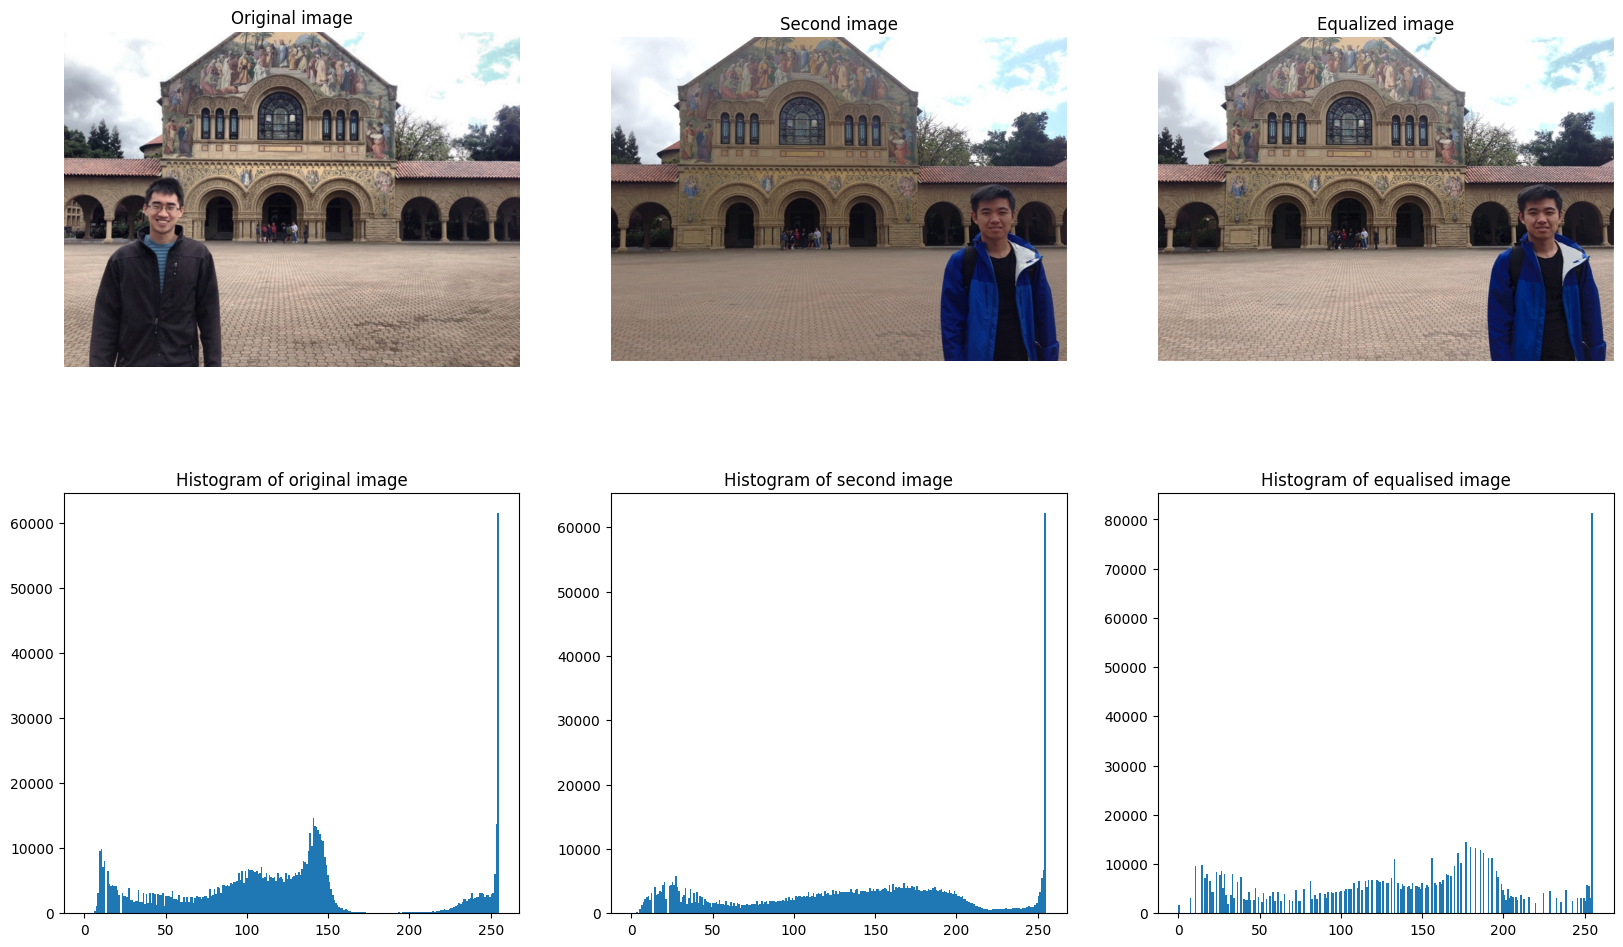

In [38]:
fig = plt.figure(figsize = (20,12))
plt.subplot(2,3,1)
show_image(man, "Original image")
plt.subplot(2,3,2)
show_image(man2, "Second image")
plt.subplot(2,3,3)
show_image(hist_out, "Equalized image")

plt.subplot(2,3,4)
plt.hist(man2_l.ravel(),256,[0,255])
plt.title('Histogram of original image')
plt.subplot(2,3,5)
plt.hist(man_l.ravel(),256,[0,255])
plt.title('Histogram of second image')
plt.subplot(2,3,6)
plt.hist(hist_out_l.ravel(),256,[0,255])
plt.title('Histogram of equalised image')
plt.show()

In [39]:
man = man
man2 = hist_out

In [40]:
def findBoundingBoxFace(img):
    # using cv2 cascade classifier
    face_cascade = cv.CascadeClassifier()
    face_cascade.load(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, 1.3, 5)

    if(len(faces) == 0):
        return None
    bigFace = (0, 0, 0, 0)
    for i in range(len(faces)):
        if(faces[i][2]*faces[i][3] > bigFace[2]*bigFace[3]):
            bigFace = faces[i]
    (x, y, w, h) = bigFace
    return (x, y, w, h)    

In [41]:
def findBoundingBoxes(img):
    (x, y, w, h) = findBoundingBoxFace(img)
    if(x == None):
        return None
    (xb, yb, wb, hb) = (x-w, y-h, 3*w, img.shape[0] - y +h)
    return (xb, yb, wb, hb), (x, y, w, h)

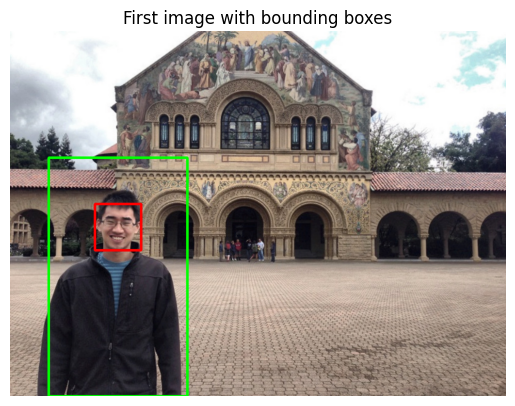

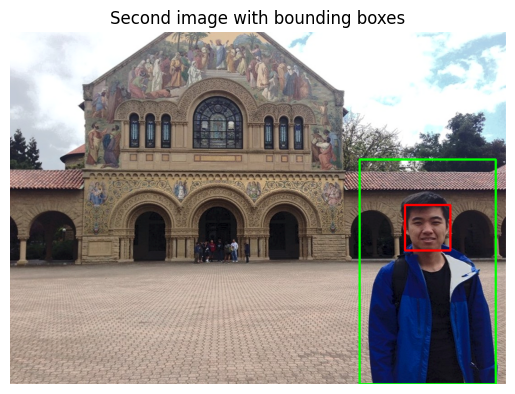

In [42]:
grayMan = cv.cvtColor(man, cv.COLOR_RGB2GRAY)
boxMan = man.copy()
grayMan2 = cv.cvtColor(man2, cv.COLOR_RGB2GRAY)
boxMan2 = man2.copy()

body, face = findBoundingBoxes(grayMan)
body2, face2 = findBoundingBoxes(grayMan2)

if face is None:
    print("No face found")
else:
    (xb, yb, wb, hb), (x, y, w, h) = body, face
    cv.rectangle(boxMan, (xb, yb), (xb+wb, yb+hb), (0, 255, 0), 3)
    cv.rectangle(boxMan, (x, y), (x+w, y+h), (255, 0, 0), 3)
    # interchange r and b
    cv.imwrite('../data/outs/boxMan.png', cv.cvtColor(boxMan, cv.COLOR_RGB2BGR))

if face2 is None:
    print("No face found")
else:
    (xb, yb, wb, hb), (x, y, w, h) = body2, face2
    cv.rectangle(boxMan2, (xb, yb), (xb+wb, yb+hb), (0, 255, 0), 3)
    cv.rectangle(boxMan2, (x, y), (x+w, y+h), (255, 0, 0), 3)
    # interchange r and b
    cv.imwrite('../data/outs/boxMan2.png', cv.cvtColor(boxMan2, cv.COLOR_RGB2BGR))

show_image(boxMan, "First image with bounding boxes")
plt.figure()
show_image(boxMan2, "Second image with bounding boxes")

In [43]:
def harris_corner_detector(img):
 
 gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
 # apply sobel filter in to get gradient image
 gray_dx = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
 gray_dy = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)

 img_harris = np.zeros(gray.shape)

 for i in range(1, gray.shape[0]-1):
    for j in range(1, gray.shape[1]-1):
        
        dx = np.zeros((3, 3))
        dy = np.zeros((3, 3))
      
        dx = gray_dx[i-1:i+2, j-1:j+2]
        dy = gray_dy[i-1:i+2, j-1:j+2]

        # calculate the sum of squares of derivatives
        dx2 = np.sum(dx*dx)
        dy2 = np.sum(dy*dy)
        dxdy = np.sum(dx*dy)

        # matrix of sum of squares of derivatives
        M = np.array([[dx2, dxdy], [dxdy, dy2]])

        # calculate the harris response
        img_harris[i, j] = np.linalg.det(M) - 0.04 * np.trace(M) * np.trace(M)

 # threshold the harris response
 img_harris[img_harris < 0.01 * img_harris.max()] = 0

 # get the x and y coordinates of the corners
 img_harris_x = np.where(img_harris != 0)[1]
 img_harris_y = np.where(img_harris != 0)[0]

 radius = 3

 img_harris_x = img_harris_x.astype(float)
 img_harris_y = img_harris_y.astype(float)
 
 # get the descriptors of the corners using orb.detect 
 orb = cv.ORB_create()

 kp = [cv.KeyPoint(x, y, radius) for x, y in zip(img_harris_x, img_harris_y)]
 
 kp, des = orb.compute(img, kp)

 return kp, des 

def match_keypoints(des1, des2):
    bf = cv.BFMatcher.create(cv.NORM_HAMMING, crossCheck=True)    # this should be brute force hamming
    matches = bf.match(des1, des2)
    sorted_matches = sorted(matches, key=lambda x: x.distance, reverse=True)
    return sorted_matches

# Print lines that connect matching keypoints across two images
def display_keypoint_matches(img1, img2, kp1, kp2, matches):
    concat_image = np.concatenate((img1, img2), axis=1)
    h, w = img1.shape[:2]
    for m in matches:
        color = (0, 255, 0)
        cv.line(concat_image, (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1])), (int(kp2[m.trainIdx].pt[0] + w), int(kp2[m.trainIdx].pt[1])), color)
    
    plt.imshow(concat_image)
    cv.waitKey(0)
    cv.destroyAllWindows()

# Prune matches based distance attribute
def prune_keypoint_matches_by_distance(matches):
    FACTOR = 10
    pruned_matches = []
    threshold = matches[-1].distance * FACTOR
    for m in matches:
        if m.distance < threshold:
            pruned_matches.append(m)
    return pruned_matches


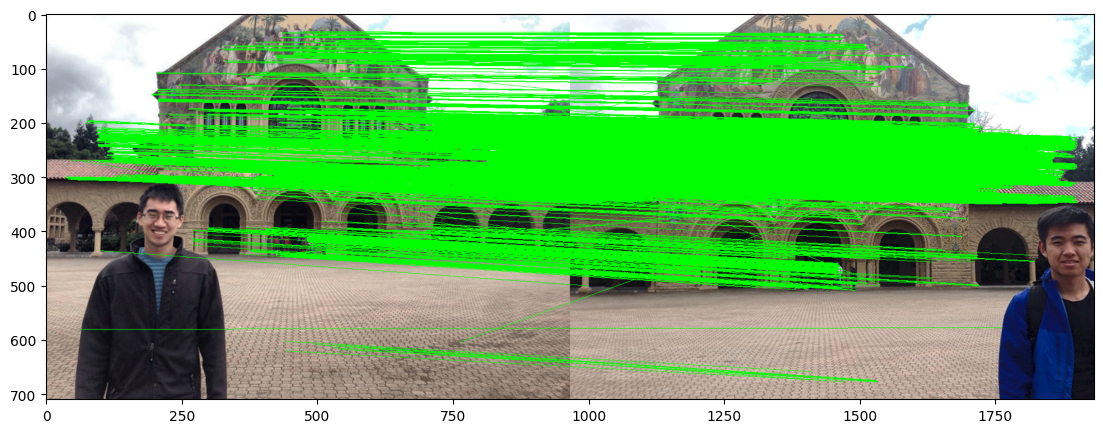

In [44]:
# crop img1 to img2 size
out_dim = (min(man.shape[0],man2.shape[0]),min(man.shape[1],man2.shape[1]))
man2 = man2[:out_dim[0], :out_dim[1]]
man = man[:out_dim[0], :out_dim[1]]
#call the function 
kp1, des1 = harris_corner_detector(man)
kp2, des2 = harris_corner_detector(man2)

matches = match_keypoints(des1, des2)

pruned_matches = prune_keypoint_matches_by_distance(matches)

plt.figure(figsize=(20, 5))
display_keypoint_matches(man, man2, kp1, kp2, pruned_matches)

In [45]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
transform_M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)                  #RANSAC
warped_man = cv.warpPerspective(man,transform_M,out_dim[::-1],)


In [46]:
man = warped_man
man2 = man2
grayMan = cv.cvtColor(man, cv.COLOR_RGB2GRAY)
boxMan = man.copy()
grayMan2 = cv.cvtColor(man2, cv.COLOR_RGB2GRAY)
boxMan2 = man2.copy()

body, face = findBoundingBoxes(grayMan)
body2, face2 = findBoundingBoxes(grayMan2)

False

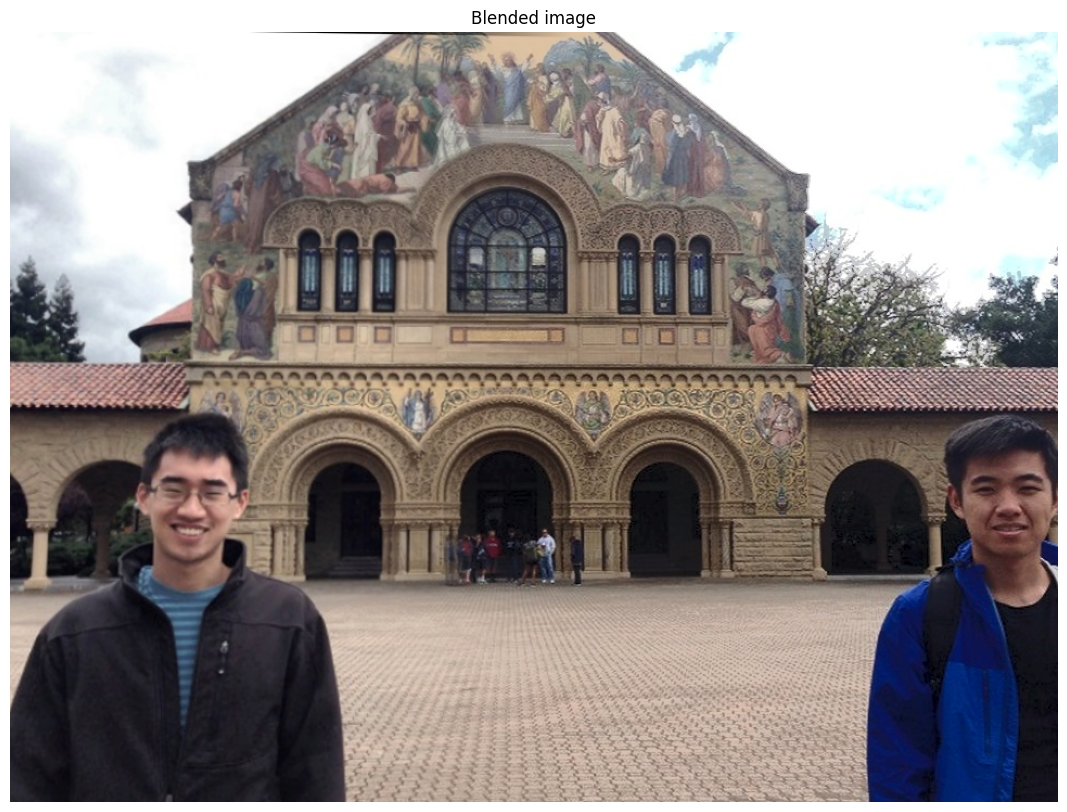

In [47]:
# Blends between columns start and end
def alpha_blend(img_left, img_right, start, end):
    end = end+1  # Include the last column in computation
    step_size = 1.0/(end-start)
    img_left_cut = img_left[:,start:end,:]
    img_right_cut = img_right[:,start:end,:]
    
    alpha = np.arange(0, end-start)*step_size
    alpha = np.reshape(alpha,(1,-1,1))

    out_mid = img_left_cut*(1-alpha) + img_right_cut*(alpha)
    
    out = img_left.copy()
    out[:,start:end,:] = out_mid
    out[:,end:,:] = img_right[:,end:,:]

    return out
(xb, yb, wb, hb), (x, y, w, h) = body, face
(xb2, yb2, wb2, hb2), (x2, y2, w2, h2) = body2, face2
blended_out = alpha_blend(man, man2, xb+wb, xb2-wb2)
plt.figure(figsize=(20, 10))
show_image(blended_out, "Blended image")
cv.imwrite('../data/outs/blended.png', cv.cvtColor(blended_out, cv.COLOR_RGB2BGR))